<a href="https://colab.research.google.com/github/the-astronot/intro_to_ai/blob/main/Homework4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 4

In [ ]:
# Mass imports
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.preprocessing import Normalizer
import warnings
import datetime as dt
warnings.filterwarnings("ignore")

## Section 1

I found a dataset on Kaggle for [Stock Info](https://www.kaggle.com/datasets/szrlee/stock-time-series-20050101-to-20171231) for the a decade's worth of time. I plan on trying to use RNNs to predict future closing prices. This seemed to be one of the few applications that would be easier to assign values to the training/predictions of.

## Exploratory Data Analysis

In [ ]:
# Loading the dataset
df = pd.read_csv('all_stocks_2006-01-01_to_2018-01-01.csv')
df.head(10)

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,77.76,79.35,77.24,79.11,3117200,MMM
1,2006-01-04,79.49,79.49,78.25,78.71,2558000,MMM
2,2006-01-05,78.41,78.65,77.56,77.99,2529500,MMM
3,2006-01-06,78.64,78.90,77.64,78.63,2479500,MMM
4,2006-01-09,78.50,79.83,78.46,79.02,1845600,MMM
5,2006-01-10,79.00,79.01,78.08,78.53,1919900,MMM
6,2006-01-11,78.44,78.66,77.84,78.37,1911900,MMM
7,2006-01-12,78.20,78.23,77.20,77.70,2121100,MMM
8,2006-01-13,76.95,78.20,76.95,77.50,1925300,MMM
9,2006-01-17,77.10,77.62,77.00,77.09,2073400,MMM


I get the feeling that the ISO DateTime won't work very well, so I'll add a quick function to go about replacing it.

In [ ]:
def to_date(string):
  date = dt.datetime.fromisoformat(string)
  return date

In [ ]:
start_date = to_date(df['Date'][0])
df["DaysTime"] = 0
for i in range(len(df["DaysTime"])):
  df["DaysTime"][i] = (to_date(df['Date'][i])-start_date).days

Looks like everything went alright there. Now for a quick peek at the layout of the dataset.

In [ ]:
df.describe()

,Open,High,Low,Close,Volume,DaysTime
count,93587.000000,93602.000000,93592.000000,93612.000000,9.361200e+04,93612.000000
mean,85.623260,86.387045,84.836664,85.641753,2.015667e+07,2189.678759
std,108.151723,108.956365,107.225361,108.121106,3.442108e+07,1264.913560
min,6.750000,7.170000,0.000000,6.660000,0.000000e+00,0.000000
25%,33.950000,34.290000,33.600000,33.960000,5.040180e+06,1093.000000
50%,60.040000,60.630000,59.490000,60.050000,9.701142e+06,2187.000000
75%,94.000000,94.740000,93.250000,94.012500,2.075222e+07,3286.000000
max,1204.880000,1213.410000,1191.150000,1195.830000,8.432640e+08,4378.000000


Everything is looking okay from a data standpoint. I am seeing a few missing opens, lows, and highs, so I'll go ahead and drop those.

In [ ]:
df = df[df["Open"].isna() == False]
df = df[df["High"].isna() == False]
df = df[df["Low"].isna() == False]
df.describe()

,Open,High,Low,Close,Volume,DaysTime
count,93587.000000,93587.000000,93587.000000,93587.000000,9.358700e+04,93587.000000
mean,85.623260,86.382961,84.836485,85.634973,2.015982e+07,2189.154028
std,108.151723,108.962620,107.227791,108.130598,3.442490e+07,1264.661432
min,6.750000,7.170000,0.000000,6.660000,8.708300e+04,0.000000
25%,33.950000,34.290000,33.600000,33.950000,5.040876e+06,1093.000000
50%,60.040000,60.620000,59.490000,60.040000,9.702410e+06,2186.000000
75%,94.000000,94.740000,93.250000,94.000000,2.075386e+07,3284.000000
max,1204.880000,1213.410000,1191.150000,1195.830000,8.432640e+08,4378.000000


Much better. I'll plot a few of the indices to get a feel for the data. I chose close prices on a whim, seemed as good as any other feature.

## NA Check

In [ ]:
df.isna().sum()

Date        0
Open        0
High        0
Low         0
Close       0
Volume      0
Name        0
DaysTime    0
dtype: int64

In [ ]:
indices = {}
indices["AAPL"] = df[df["Name"]=="AAPL"]
indices["AMZN"] = df[df["Name"]=="AMZN"]
indices["GOOGL"] = df[df["Name"]=="GOOGL"]
indices["MSFT"] = df[df["Name"]=="MSFT"]
indices["VZ"] = df[df["Name"]=="VZ"]

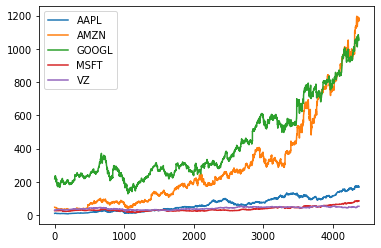

In [ ]:
for index in indices:
  plt.plot(indices[index].DaysTime,indices[index].Close,label=index)
plt.legend()

Adding in the rest of the stocks...

In [ ]:
stonks = ['MMM', 'AXP', 'BA', 'CAT', 'CVX', 'CSCO', 'KO', 'DIS', 'XOM', 'GE',
      'GS', 'HD', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MRK', 'NKE', 'PFE',
      'PG', 'TRV', 'UTX', 'UNH', 'WMT', 'AABA']
for stonk in stonks:
  indices[stonk] = df[df["Name"]==stonk]

After some testing, I have removed Amazon and Google as their values are well above the others and lead to larger errors.

In [ ]:
indices.pop("AMZN")
indices.pop("GOOGL")

,Date,Open,High,Low,Close,Volume,Name,DaysTime
84555,2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL,0
84556,2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL,1
84557,2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL,2
84558,2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL,3
84559,2006-01-09,233.44,236.94,230.70,233.68,12795837,GOOGL,6
...,...,...,...,...,...,...,...,...
87569,2017-12-22,1070.00,1071.72,1067.64,1068.86,889446,GOOGL,4371
87570,2017-12-26,1068.64,1068.86,1058.64,1065.85,918767,GOOGL,4375
87571,2017-12-27,1066.60,1068.27,1058.38,1060.20,1116203,GOOGL,4376
87572,2017-12-28,1062.25,1064.84,1053.38,1055.95,994249,GOOGL,4377


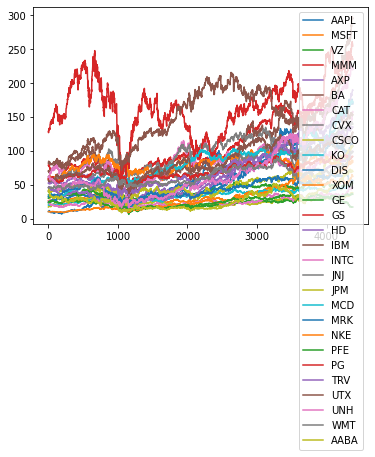

In [ ]:
for index in indices:
  plt.plot(indices[index].DaysTime,indices[index].Close,label=index)
plt.legend()

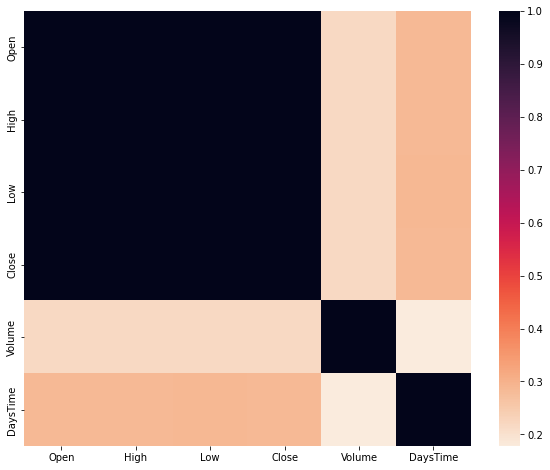

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(df.corr().abs(),annot=False, ax=ax, cmap='rocket_r')

I'm not really sure what I expected here, obviously the prices are going to be highly correlated to each other with some relation to the daystime as the stock prices increase over this period.

# The Model

In [ ]:
def proc_data(source,days):
  size = source.shape[0]-days
  train_size = int(0.8*size)
  valid_size = int(0.1*size)
  test_size = int(0.1*size)
  valid_list = source[:valid_size]
  test_list = source[valid_size:valid_size+test_size]
  train_list = source[valid_size+test_size:valid_size+test_size+train_size]
  x_train = np.zeros(shape=(len(train_list)+1-days,days))
  x_valid = np.zeros(shape=(len(valid_list)+1-days,days))
  x_test = np.zeros(shape=(len(test_list)+1-days,days))
  y_train = np.zeros(shape=(x_train.shape[0]))
  y_valid = np.zeros(shape=(x_valid.shape[0]))
  y_test = np.zeros(shape=(x_test.shape[0]))
  t = 0
  tt = 0
  for i in range(x_test.shape[0]):
    for j in range(days):
      x_test[i][j] = source[i+j]
    y_test[i] = source[days+i]
    t+=1
  t+=9
  for i in range(x_valid.shape[0]):
    for j in range(days):
      x_valid[i][j] = source[t+i+j]
    y_valid[i] = source[days+t+i]
    tt+=1
  tt+=9
  for i in range(x_train.shape[0]):
    for j in range(days):
      x_train[i][j] = source[t+tt+i+j]
    y_train[i] = source[days+t+tt+i]
  return x_train, x_valid, x_test, y_train, y_valid, y_test

In [ ]:
class Trainer:
  def __init__(self,names_dict):
    self.names_dict = names_dict
    self.x_train = None
    self.x_valid = None
    self.x_test = None
    self.y_train = None
    self.y_valid = None
    self.y_test = None
    self.model = None
    self.max = None

  def get_max(self):
    if self.max is None:
      self.max = 0
      for key in self.names_dict:
        self.max = max([max(self.names_dict[key]),self.max])

  def separate_all(self):
    self.get_max()
    for key in self.names_dict:
      x = self.names_dict[key]/self.max
      x_train, x_valid, x_test, y_train, y_valid, y_test = separate(x)
      if self.x_train is None:
        self.x_train = x_train
        self.x_valid = x_valid
        self.x_test = x_test
        self.y_train = y_train
        self.y_valid = y_valid
        self.y_test = y_test
      else:
        self.x_train = np.concatenate((self.x_train,x_train))
        self.x_valid = np.concatenate((self.x_valid,x_valid))
        self.x_test = np.concatenate((self.x_test,x_test))
        self.y_train = np.concatenate((self.y_train,y_train))
        self.y_valid = np.concatenate((self.y_valid,y_valid))
        self.y_test = np.concatenate((self.y_test,y_test))
    
  def create_model(self):
    self.model = keras.Sequential()
    self.model.add(layers.SimpleRNN(4, input_shape=(10,1), activation='tanh'))
    self.model.add(layers.Dense(1))
    print(self.model.summary())
    self.model.compile(
      loss="mean_squared_error",
      optimizer="adamax"
    )

  def create_lstm_model(self):
    self.model = keras.Sequential()
    self.model.add(layers.LSTM(4, input_shape=(10,1), activation='tanh'))
    self.model.add(layers.Dense(1))
    print(self.model.summary())
    self.model.compile(
      loss="mean_squared_error",
      optimizer="adamax"
    )
  
  def create_gru_model(self):
    self.model = keras.Sequential()
    self.model.add(layers.GRU(4, input_shape=(10,1), activation='tanh'))
    self.model.add(layers.Dense(1))
    print(self.model.summary())
    self.model.compile(
      loss="mean_squared_error",
      optimizer="adamax"
    )

  def train(self, epochs=10, batch_size=32, show_graph=True):
    his = self.model.fit(
      self.x_train, self.y_train, validation_data=(self.x_valid, self.y_valid), batch_size=batch_size, epochs=epochs
    )
    if show_graph:
      plt.plot(his.history['loss'])
      plt.plot(his.history['val_loss'])
      plt.title('model loss')
      plt.ylabel('loss')
      plt.xlabel('epoch')
      plt.legend(['loss','val_loss'])
      plt.show()
    predicted_prices = self.model.predict(self.x_valid)
    return get_avg_err(predicted_prices,self.y_valid)

  def test(self):
    predicted_prices = self.model.predict(self.x_test)
    plt.plot(self.y_test*self.max, color='black', label="Actual")
    plt.plot(predicted_prices*self.max, color= 'green', label="Predicted")
    plt.title("Stonks")
    plt.xlabel("Time")
    plt.ylabel("Price ($)")
    plt.legend()
    plt.show()
    return get_avg_err(predicted_prices,self.y_test)

def get_avg_err(pred,real):
  err = 0
  for i in range(real.shape[0]):
    err += abs(real[i]-pred[i])/real[i]
  return err/float(real.shape[0])

In [ ]:
# Testing the data separator
def separate(x):
  x_train, x_valid, x_test, y_train, y_valid, y_test = proc_data(x,10)
  #print(x)
  #print(x_train)
  #print(y_train)
  #print(x_valid)
  #print(y_valid)
  #print(x_test.shape)
  #print(y_test)
  x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
  x_valid = np.reshape(x_valid, (x_valid.shape[0], x_valid.shape[1], 1))
  x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
  #print(x_train.shape)
  return x_train, x_valid, x_test, y_train, y_valid, y_test



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 4)                 24        
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 29
Trainable params: 29
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
2174/2174 [==============================] - 8s 3ms/step - loss: 8.5372e-04 - val_loss: 1.6364e-04
Epoch 2/20
2174/2174 [==============================] - 7s 3ms/step - loss: 1.3918e-04 - val_loss: 1.1277e-04
Epoch 3/20
2174/2174 [==============================] - 7s 3ms/step - loss: 9.4226e-05 - val_loss: 7.8158e-05
Epoch 4/20
2174/2174 [==============================] - 8s 3ms/step - loss: 6.9325e-05 - val_loss: 5.9982e-05
Epoch 5/20


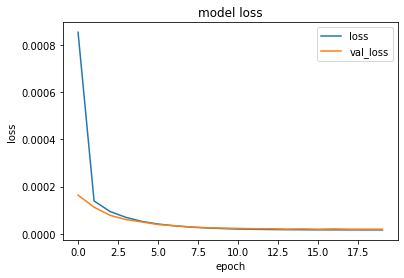

264/264 [==============================] - 1s 2ms/step


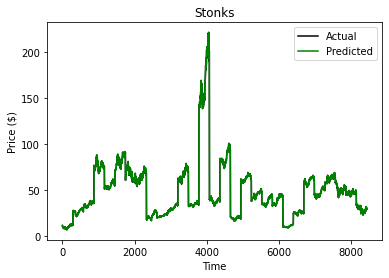

AVERAGE_ERROR_VALID: 1.312% = $3.91
AVERAGE_ERROR_TEST: 1.000% = $2.98


In [ ]:
names_dict = {}
for key in indices:
  names_dict[key] = indices[key].Close.values
trainer = Trainer(names_dict)
trainer.separate_all()
trainer.create_model()
valid_avg_err = trainer.train(epochs=20)[0]
test_avg_err = trainer.test()[0]
maximum = trainer.max
print("AVERAGE_ERROR_VALID: {0:.3f}% = ${1:.2f}".format(valid_avg_err*100.0,valid_avg_err*maximum))
print("AVERAGE_ERROR_TEST: {0:.3f}% = ${1:.2f}".format(test_avg_err*100.0,test_avg_err*maximum))

## Better than I would have figured

I didn't come into this task with much hope for a useful model coming out the other side, but this is actually better than I had hoped for. It certainly wouldn't be making anybody any money, but its predictions aren't ludicrous, so that's a start.

# LSTM Time

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4)                 96        
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
2174/2174 [==============================] - 15s 6ms/step - loss: 0.0090 - val_loss: 1.4654e-04
Epoch 2/20
2174/2174 [==============================] - 13s 6ms/step - loss: 7.6927e-05 - val_loss: 6.1636e-05
Epoch 3/20
2174/2174 [==============================] - 12s 6ms/step - loss: 4.8191e-05 - val_loss: 5.5734e-05
Epoch 4/20
2174/2174 [==============================] - 13s 6ms/step - loss: 4.0928e-05 - val_loss: 4.5013e-05
Epoch 5

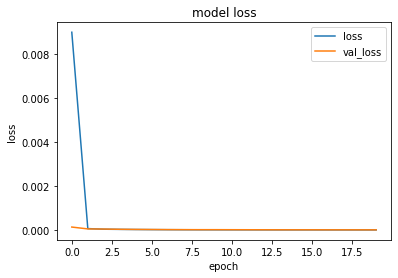

264/264 [==============================] - 1s 2ms/step


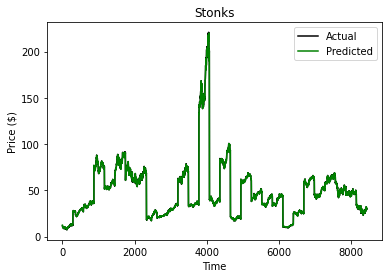

AVERAGE_ERROR_VALID: 1.337% = $3.98
AVERAGE_ERROR_TEST: 1.065% = $3.17


In [ ]:
lstm = Trainer(names_dict)
lstm.separate_all()
lstm.create_lstm_model()
valid_avg_err = lstm.train(epochs=20)[0]
test_avg_err = lstm.test()[0]
maximum = lstm.max
print("AVERAGE_ERROR_VALID: {0:.3f}% = ${1:.2f}".format(valid_avg_err*100.0,valid_avg_err*maximum))
print("AVERAGE_ERROR_TEST: {0:.3f}% = ${1:.2f}".format(test_avg_err*100.0,test_avg_err*maximum))

# GRU

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 4)                 84        
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
2174/2174 [==============================] - 17s 7ms/step - loss: 0.0129 - val_loss: 2.9708e-05
Epoch 2/20
2174/2174 [==============================] - 15s 7ms/step - loss: 2.5797e-05 - val_loss: 2.5503e-05
Epoch 3/20
2174/2174 [==============================] - 15s 7ms/step - loss: 2.1981e-05 - val_loss: 2.2321e-05
Epoch 4/20
2174/2174 [==============================] - 14s 7ms/step - loss: 1.9544e-05 - val_loss: 2.0772e-05
Epoch 5/2

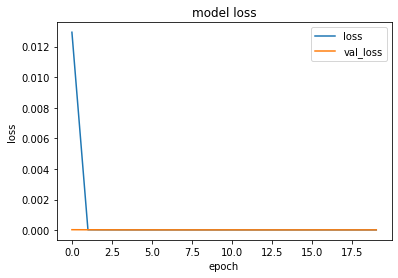

264/264 [==============================] - 1s 2ms/step


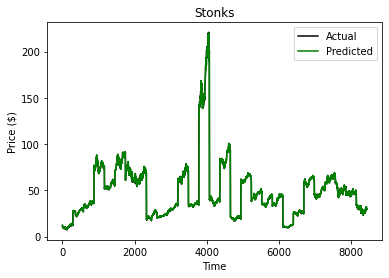

AVERAGE_ERROR_VALID: 1.328% = $3.96
AVERAGE_ERROR_TEST: 1.143% = $3.40


In [ ]:
gru = Trainer(names_dict)
gru.separate_all()
gru.create_gru_model()
valid_avg_err = gru.train(epochs=20)[0]
test_avg_err = gru.test()[0]
maximum = gru.max
print("AVERAGE_ERROR_VALID: {0:.3f}% = ${1:.2f}".format(valid_avg_err*100.0,valid_avg_err*maximum))
print("AVERAGE_ERROR_TEST: {0:.3f}% = ${1:.2f}".format(test_avg_err*100.0,test_avg_err*maximum))

# Comparison

For this particular task, I'm not seeinga big difference between the different models aside from the number of weights that they are training and the resulting time increases from GRUs and LSTMs. I imagine with a problem that more differentiable inputs than simply past prices (words,etc) that going with an LSTM would have showed itself to be a better option. As it stands for this case however, it just seems to take longer.

# Viability using a different model

I don't imagine that you'd be quite as successful with a "normal" neural net for this task. While I suppose that the inputs will create some form of nonlinear equation that points towards the output, I am not confident that a regular neural net would be able to pick it out as well. Since I could turn each of the values in the time-based data into a separate feature (as I am currently only using the one feature), I suppose creating a neural net as deep as my time series input was long could achieve similar functionality to a RNN. That would be a very specialized neural net, however.

# Similarity - PART 2

First I'll load in the data from word2vec. I exported the weights of the shakespearean writings produced by word2vec and loaded the metadata and vectors into this workbook.

In [7]:
w = open("metadata.tsv","r")
v = open("vectors.tsv", "r")
words = w.read().strip("\n").split("\n")
vectors = []
vect_read = v.read().strip("\n").split("\n")
words.pop(0)
vect_read.pop(0)
for vect in vect_read:
  vectors.append(np.asarray(vect.split("\t"),dtype=float))
w.close()
v.close()
dictionary = {}
for i in range(len(words)):
  dictionary[words[i]] = vectors[i]

## Cosine Similarity

In [8]:
def cossim(X,Y):
  #print(X.shape, Y.shape)
  prod = np.dot(X,Y)
  #print(prod)
  X_sqrd = np.square(X)
  newX = np.sqrt(np.sum(X_sqrd))
  #print(newX)
  Y_sqrd = np.square(Y)
  newY = np.sqrt(np.sum(Y_sqrd))
  #print(newY)
  return prod/(newX*newY)

In [9]:
print("Want->Need:",cossim(dictionary["want"],dictionary["need"]))
print("Love->Hate:",cossim(dictionary["love"],dictionary["hate"]))
print("Hope->Fear:",cossim(dictionary["hope"],dictionary["fear"]))
print("King->Queen:",cossim(dictionary["king"],dictionary["queen"]))
print("Helm->Fruit:",cossim(dictionary["helm"],dictionary["fruit"]))
print("Today->Tomorrow:",cossim(dictionary["today"],dictionary["tomorrow"]))
print("Heart->Heart:",cossim(dictionary["heart"],dictionary["heart"]))

Want->Need: 0.36037132039835407
Love->Hate: 0.12369413535185367
Hope->Fear: 0.009107819280739962
King->Queen: 0.16943026931786342
Helm->Fruit: -0.0922283060437243
Today->Tomorrow: -0.02354748161402274
Heart->Heart: 0.9999999999999998


# Dissimilarity

The obvious way to measure dissimilarity would be to simply return -1*cosine similarity. I would figure that the opposite score of the similarity would be the dissimilarity of the 2 given words.

In [10]:
def dissim(X,Y):
  return -1*cossim(X,Y)

In [11]:
print("Want->Need:",dissim(dictionary["want"],dictionary["need"]))
print("Love->Hate:",dissim(dictionary["love"],dictionary["hate"]))
print("Hope->Fear:",dissim(dictionary["hope"],dictionary["fear"]))
print("King->Queen:",dissim(dictionary["king"],dictionary["queen"]))
print("Helm->Fruit:",dissim(dictionary["helm"],dictionary["fruit"]))
print("Today->Tomorrow:",dissim(dictionary["today"],dictionary["tomorrow"]))
print("Heart->Heart:",dissim(dictionary["heart"],dictionary["heart"]))

Want->Need: -0.36037132039835407
Love->Hate: -0.12369413535185367
Hope->Fear: -0.009107819280739962
King->Queen: -0.16943026931786342
Helm->Fruit: 0.0922283060437243
Today->Tomorrow: 0.02354748161402274
Heart->Heart: -0.9999999999999998


# Alternative Dissimilaity

An alternate measure for dissimilarity would be the Euclidean Distance between the 2 word vectors. Here lower values are more similar, and higher values are more dissimilar.

In hindsight, this doesn't work well, and shouldn't due to the vector nature of the arguments. The cosine similarity is nice because it is able to take into account the orthogonality of the different vectors to find vectors that are related, but not necessarily similar or dissimilar. This distance algorithm on the other hand loses the nuance that the other algorithm operates under. It would seem that my original dissimilarity algorithm, though derivative, does a better job at performing its expected duties.

In [12]:
def altdissim(X,Y):
  Z = Y-X
  return np.sqrt(np.sum(np.square(Z)))

In [13]:
print("Want->Need:",altdissim(dictionary["want"],dictionary["need"]))
print("Love->Hate:",altdissim(dictionary["love"],dictionary["hate"]))
print("Hope->Fear:",altdissim(dictionary["hope"],dictionary["fear"]))
print("King->Queen:",altdissim(dictionary["king"],dictionary["queen"]))
print("Helm->Fruit:",altdissim(dictionary["helm"],dictionary["fruit"]))
print("Today->Tomorrow:",altdissim(dictionary["today"],dictionary["tomorrow"]))
print("Heart->Heart:",altdissim(dictionary["heart"],dictionary["heart"]))

Want->Need: 2.6705754759752662
Love->Hate: 2.792847558972841
Hope->Fear: 3.1523443626677605
King->Queen: 3.453621021157361
Helm->Fruit: 2.4450285972703263
Today->Tomorrow: 2.847639692088651
Heart->Heart: 0.0


In [14]:
def check(word1, word2):
  if word1 not in dictionary:
    return "{} not in dictionary...".format(word1)
  if word2 not in dictionary:
    return "{} not in dictionary...".format(word2)
  X = dictionary[word1]
  Y = dictionary[word2]
  return "Words: {}, {}\nSimilarity: {:.3f}\nDissimilarity: {:.3f}\nAlt_Dissimilarity: {:.3f}".format(word1,word2,cossim(X,Y),dissim(X,Y),altdissim(X,Y))

# User Input

I have written a function to take 2 user entered words and find the similarity/dissimilarity between them. Try it out in the code below.

In [16]:
print(check("test","test"))

test not in dictionary...
